# Step 04
# Evaluation of performance

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb

import skimage.io
import skimage.morphology
import skimage.segmentation

import utils.evaluation
import utils.metrics
from config import config_vars

Using TensorFlow backend.


# Configuration

In [36]:

# Partition of the data to make predictions (test or validation)
config_vars['path_files_training'] = '/home/maloua/Malou_Master/5_Models/5_Green_channel_models/data/4_filelists/2_training.txt'
config_vars['path_files_validation'] ='/home/maloua/Malou_Master/5_Models/5_Green_channel_models/data/4_filelists/2_VALIDATION.txt'
config_vars['path_files_test'] = '/home/maloua/Malou_Master/5_Models/2_Final_Models/data/4_filelists/TEST.txt'

partition = "validation"

experiment_name = 'Model_3'

config_vars['results_path'] = '/home/maloua/Malou_Master/5_Models/5_Green_channel_models/data/results/' + experiment_name + "/"

os.makedirs(config_vars['results_path'], exist_ok = True)

config_vars = utils.dirtools.setup_experiment(config_vars, experiment_name)

data_partitions = utils.dirtools.read_data_partitions(config_vars)

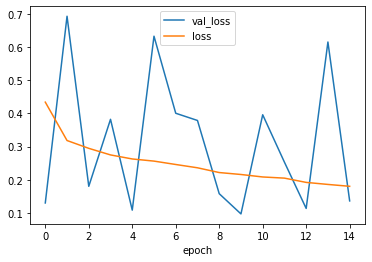

In [33]:

modellog = pd.read_csv(config_vars["csv_log_file"])
#print(modellog.dtypes)

pd.DataFrame.plot(modellog)
ax = plt.gca()
modellog.plot(x = 'epoch', y = 'val_loss', ax = ax)
modellog.plot(x = 'epoch', y = 'loss', ax = ax)

In [4]:
# To evaluate segmentations produced by other segmentation algorithms (e.g. CellProfiler), 
# manually modify the following config var:

#config_vars["labels_out_dir"] = "/data/cellprofiler_segmentations/"
#config_vars["object_dilation"] = 2

# Auxiliary visualization function

In [5]:
# Display prediction along with segmentation to visualize errors

def show(ground_truth, prediction, threshold=0.5, image_name="N"):
    
    # Compute Intersection over Union
    IOU = utils.evaluation.intersection_over_union(ground_truth, prediction)
    
    # Create diff map
    diff = np.zeros(ground_truth.shape + (3,))
    A = ground_truth.copy()
    B = prediction.copy()
    A[A > 0] = 1
    B[B > 0] = 1
    D = A - B
    #diff[D > 0,:2] = 1
    #diff[D < 0,1:] = 1
    
    # Object-level errors
    C = IOU.copy()
    C[C>=threshold] = 1
    C[C<threshold] = 0
    missed = np.where(np.sum(C,axis=1) == 0)[0]
    extra = np.where(np.sum(C,axis=0) == 0)[0]

    for m in missed:
        diff[ground_truth == m+1, 0] = 1
    for e in extra:
        diff[prediction == e+1, 2] = 1
    
    # Display figures
    fig, ax = plt.subplots(1, 4, figsize=(18,6))
    ax[0].imshow(ground_truth)
    ax[0].set_title("True objects:"+str(len(np.unique(ground_truth))))
    ax[1].imshow(diff)
    ax[1].set_title("Segmentation errors:"+str(len(missed)))
    ax[2].imshow(prediction)
    ax[2].set_title("Predicted objects:"+str(len(np.unique(prediction))))
    ax[3].imshow(IOU)
    ax[3].set_title(image_name)

# Run the evaluation
Predictions are stored in Step 03 and loaded here for evaluation

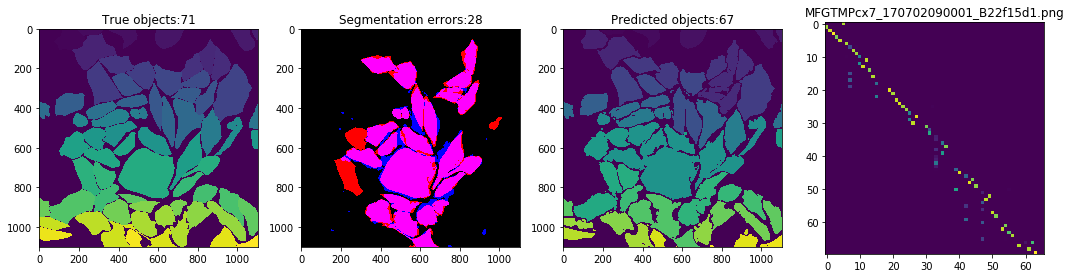

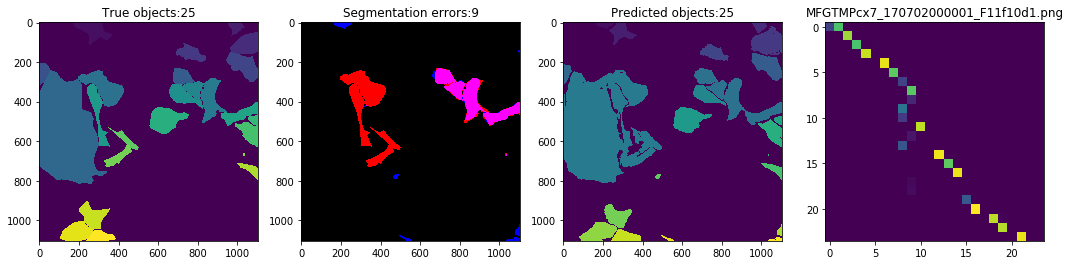

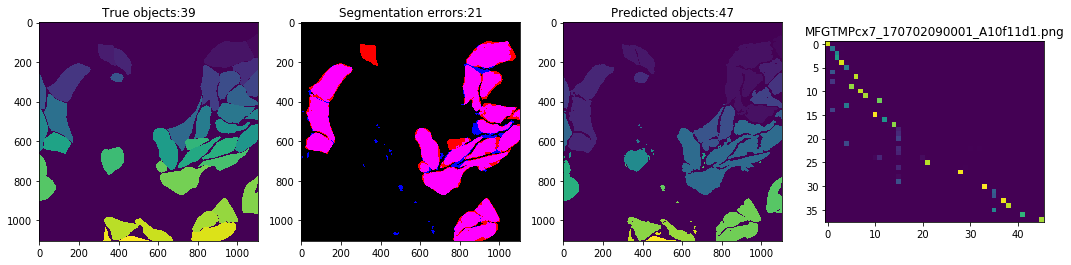

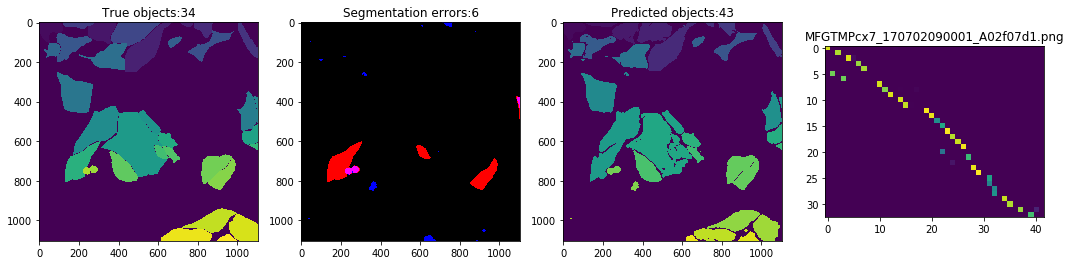

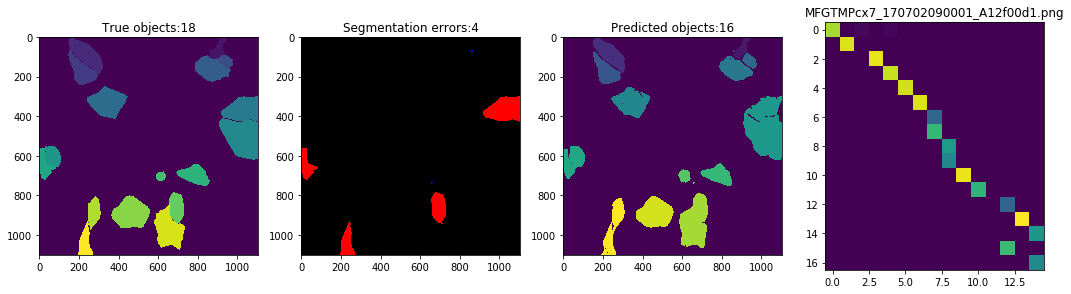

In [6]:
all_images = data_partitions[partition]
from skimage.color import rgb2gray,rgb2lab

results = pd.DataFrame(columns=["Image", "Threshold", "F1", "Jaccard", "TP", "FP", "FN"])
false_negatives = pd.DataFrame(columns=["False_Negative", "Area"])
false_positives = pd.DataFrame(columns=["False_Positive", "Area"])
splits_merges = pd.DataFrame(columns=["Image_Name", "Merges", "Splits"])

for image_name in all_images:
    # Load ground truth data
    img_filename = os.path.join(config_vars["raw_annotations_dir"], image_name)
    ground_truth = skimage.io.imread(img_filename)
    #ground_truth = ground_truth.squeeze()
    if len(ground_truth.shape) == 3:
        ground_truth = rgb2lab(ground_truth)
        ground_truth = ground_truth[:,:,0]
    
    ground_truth = skimage.morphology.label(ground_truth)
    
    # Transform to label matrix
    #ground_truth = skimage.morphology.label(ground_truth)
    
    # Load predictions
    pred_filename = os.path.join(config_vars["labels_out_dir"], image_name)
    prediction = skimage.io.imread(pred_filename)
    
    # Apply object dilation
    if config_vars["object_dilation"] > 0:
        struct = skimage.morphology.square(config_vars["object_dilation"])
        prediction = skimage.morphology.dilation(prediction, struct)
    elif config_vars["object_dilation"] < 0:
        struct = skimage.morphology.square(-config_vars["object_dilation"])
        prediction = skimage.morphology.erosion(prediction, struct)
        
    ####################################################################################    
    #### Testing prediction with no small objects on annot and prediction #####
    ground_truth = skimage.morphology.remove_small_objects(ground_truth, min_size=25) 
    prediction = skimage.morphology.remove_small_objects(prediction, min_size=25)
    #####################################################################################
    
    # Relabel objects (cut margin of 30 pixels to make a fair comparison with DeepCell)
    ground_truth = skimage.segmentation.relabel_sequential(ground_truth)[0] #[30:-30,30:-30])[0]
    prediction = skimage.segmentation.relabel_sequential(prediction)[0] #[30:-30,30:-30])[0]
    
    # Compute evaluation metrics
    results = utils.evaluation.compute_af1_results(
        ground_truth, 
        prediction, 
        results, 
        image_name
    )
    
    false_negatives = utils.evaluation.get_false_negatives(
        ground_truth, 
        prediction, 
        false_negatives, 
        image_name
    )
    
    false_positives = utils.evaluation.get_false_positives(
        ground_truth, 
        prediction, 
        false_positives, 
        image_name
    )
    
    splits_merges = utils.evaluation.get_splits_and_merges(
        ground_truth, 
        prediction, 
        splits_merges, 
        image_name
    )
    
    # Display an example image
    #if image_name == all_images[0]:
    show(ground_truth, prediction, image_name=image_name)

# Report of results

,Image,Threshold,F1,Jaccard
1,MFGTMPcx7_170702090001_A02f07d1.png,0.725,0.482667,0.546092
3,MFGTMPcx7_170702090001_A12f00d1.png,0.725,0.481250,0.668939
4,MFGTMPcx7_170702090001_B22f15d1.png,0.725,0.427941,0.561443
0,MFGTMPcx7_170702000001_F11f10d1.png,0.725,0.404167,0.536065
2,MFGTMPcx7_170702090001_A10f11d1.png,0.725,0.250000,0.330501


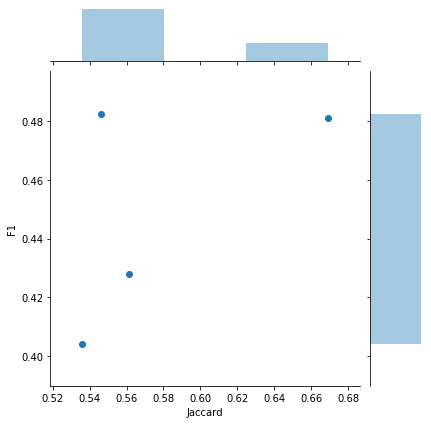

In [53]:
# Display accuracy results
pd.set_option('display.expand_frame_repr', False)
average_performance = results.groupby("Threshold").mean().reset_index()

R = results.groupby("Image").mean().reset_index()
g = sb.jointplot(data=R[R["F1"] > 0.4], x="Jaccard", y="F1")

average_performance
R.sort_values(by="F1",ascending=False)

,0,1,2,3,4,5,6,7,8,9
Threshold,0.500,0.550,0.600,0.650,0.700,0.750,0.800,0.850,0.900,0.950
F1,0.636,0.598,0.582,0.539,0.489,0.466,0.404,0.276,0.096,0.006
Jaccard,0.529,0.529,0.529,0.529,0.529,0.529,0.529,0.529,0.529,0.529


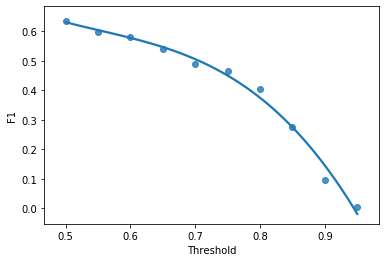

In [69]:
# Plot accuracy results
with open(config_vars['results_path'] + experiment_name + ".txt", "w") as O1:
    sb.regplot(data=average_performance, x="Threshold", y="F1", order=3, ci=None)
    average_performance = average_performance.round(3)
    print(average_performance.T, file = O1)
average_performance.T

In [70]:
# Compute and print Average F1
with open(config_vars['results_path'] + experiment_name + ".txt", "a") as O1:
    average_F1_score = average_performance["F1"].mean()
    jaccard_index = average_performance["Jaccard"].mean()
    print("\nAverage F1 score:", round(average_F1_score,3), "\n", file = O1)
    print("Jaccard index:", jaccard_index, "\n", file = O1)

In [71]:
# Summarize False Negatives by area
with open(config_vars['results_path'] + experiment_name + ".txt", "a") as O1:
    false_negatives = false_negatives[false_negatives["False_Negative"] == 1]

    FN_Area = false_negatives.groupby(
        pd.cut(
            false_negatives["Area"], 
            [0,100,1000,2100,100000], # Area intervals
            labels=["Tiny nuclei","Small nuclei","Normal nuclei","Large nuclei"],
        )
    )["False_Negative"].sum()

    print("False negatives by area \n", FN_Area, file = O1)

In [72]:
with open(config_vars['results_path'] + experiment_name + ".txt", "a") as O1:
    falseP = false_positives[false_positives["False_Positive"] == 1]

    FP_Area_chart = falseP.groupby(
        pd.cut(
            falseP["Area"], 
            [0,100,1000,2100,30000], # Area intervals
            labels=["Tiny nuclei","Small nuclei","Normal nuclei","Large nuclei"],
        )
    )["False_Positive"].sum()

    total_Positives = len(false_positives)
    print("\nFalse positives by area \n", FP_Area_chart, file = O1)

    print("\nFalse discovery rate by area\n", file = O1)

    print("FDR Tiny:", "%.4f\n" % (FP_Area_chart["Tiny nuclei"]/total_Positives), file = O1)

    print("FDR Small:", "%.4f\n" % (FP_Area_chart["Small nuclei"]/total_Positives), file = O1)

    print("FDR Normal:", "%.4f\n" % (FP_Area_chart["Normal nuclei"]/total_Positives), file = O1)

    print("FDR Large:", "%.4f\n" % (FP_Area_chart["Large nuclei"]/total_Positives), file = O1)


In [14]:
# Summarize splits and merges

print("Splits:",np.sum(splits_merges["Splits"]))
print("Merges:",np.sum(splits_merges["Merges"]))

Splits: 1
Merges: 25


In [15]:
# Report false positives

print("Extra objects (false postives):",results[results["Threshold"].round(3) == 0.7].sum()["FP"])

Extra objects (false postives): 99


In [16]:
thresh = 0.7


FP = results[results["Threshold"].round(3) == thresh].sum()["FP"]
TP = results[results["Threshold"].round(3) == thresh].sum()["TP"]
Total = FP + TP

print("Extra objects (false postives):",FP)

print("True positives:",TP)

print("Total objects:",Total)

print("False discovery rate:", FP/Total)

Extra objects (false postives): 99
True positives: 94
Total objects: 193
False discovery rate: 0.5129533678756477
